In [1]:
#----------------------------#
# 0.) Idea
#----------------------------#
# Analyze Get submssion deletion boundaries
#

#
import sys
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from collections import Counter
import matplotlib.pyplot as plt
import import_ipynb
import math

In [2]:
home_path = %pwd
data_path = "/home/pavel/Documents/Keusch_Job/Data/"
plot_path  = "/home/pavel/Documents/Keusch_Job/Tasks/deletion_boundaries/"
subroutines_path = "/home/pavel/Documents/Keusch_Job/Subroutines/"

In [3]:
#Subroutines
%cd  $subroutines_path
%run "selected_subreddits.ipynb"
%run "data_loader.ipynb"
%run "basic_plots.ipynb"
%cd  $home_path

/home/pavel/Documents/Keusch_Job/Subroutines
/home/pavel/Documents/Keusch_Job/Tasks/deletion_boundaries


In [4]:
S = load_data(data_name="SUBM_2020_01.csv", data_path = data_path)
S.head()

,author,created_utc,domain,full_link,id,is_crosspostable,is_self,is_video,num_comments,post_hint,score,selftext,subreddit,title,url,removed_by_category,link_flair_text
0,sixwaystop313,2019-12-31 22:03:48,imgur.com,https://www.reddit.com/r/Michigan/comments/ei8...,t3_ei8t50,True,False,False,8,link,1,NaN,Michigan,TIL in Traverse City skateboards and rollerbla...,https://imgur.com/JCMkFWh,NaN,NaN
1,livya15,2019-12-31 23:15:10,self.Michigan,https://www.reddit.com/r/Michigan/comments/ei9...,t3_ei9p65,True,True,False,0,NaN,1,https://www.facebook.com/83040292558/posts/101...,Michigan,Could you imagine if a sign like this was post...,https://www.reddit.com/r/Michigan/comments/ei9...,NaN,NaN
2,livya15,2020-01-01 00:03:54,nbc25news.com,https://www.reddit.com/r/Michigan/comments/eia...,t3_eiaaut,True,False,False,1,link,1,NaN,Michigan,Could you imagine if there was a sign placed a...,https://nbc25news.com/news/local/lapeer-county...,NaN,NaN
3,lishmunchkin,2020-01-01 00:10:24,self.Michigan,https://www.reddit.com/r/Michigan/comments/eia...,t3_eiaduh,True,True,False,4,NaN,1,Hubby and I are moving to Michigan in 2 weeks ...,Michigan,Hoping the new year brings good things!,https://www.reddit.com/r/Michigan/comments/eia...,NaN,NaN
4,DonSlice,2020-01-01 00:35:11,i.imgur.com,https://www.reddit.com/r/Michigan/comments/eia...,t3_eiaow3,True,False,False,6,NaN,1,NaN,Michigan,"Welcome back, Winter. You’ve been gone a while.",https://i.imgur.com/LZcd5IR.jpg,NaN,NaN


In [5]:
#----------------------------#
# 1.)  Prob deletion Descriptives
#----------------------------#

In [6]:
# I would argue to keep automod_filtered, since it is still set by the mods from what I see
#https://www.reddit.com/r/AutoModerator/comments/q11pu/what_is_automoderator/
# "Remove submissions where the title contains certain words or phrases"

In [7]:
#Some basic Stats
print("Length of Submission Data: " + str(len(S)))
print("Passible removed_by_category outputs" + str(S["removed_by_category"].unique()))
S_grouped = S.groupby(["removed_by_category"]).size().reset_index()
print(S_grouped.to_string())
print("Amount deleted: " + str(S_grouped[0].sum()))

Length of Submission Data: 404631
Passible removed_by_category outputs[nan 'moderator' 'reddit' 'deleted' 'automod_filtered' 'author']
  removed_by_category      0
0              author      8
1    automod_filtered  13926
2             deleted   5511
3           moderator  61406
4              reddit  37437
Amount deleted: 118288


In [8]:
S["removed"] = 1 
S.loc[S["removed_by_category"].isna(),"removed"] = 0 
S_grouped = S.groupby(["subreddit","removed"]).size().reset_index()
S_grouped.columns = ["subreddit","removed","count"]
print(len(S_grouped.loc[S_grouped["removed"] == 1,]))
print(len(S_grouped.loc[S_grouped["removed"] == 0,]))
print("Each subreddit has deleted at least one submission")

78
78
Each subreddit has deleted at least one submission


In [9]:
#Get remove percentages
S_grouped_deletions = S_grouped.loc[S_grouped["removed"] == 0,].merge(S_grouped.loc[S_grouped["removed"] == 1,],
                                                             how="inner", left_on="subreddit",right_on="subreddit")
S_grouped_deletions.columns = ["subreddit","deleted_x","kept","deleted_y","deleted"]
S_grouped_deletions = S_grouped_deletions.drop(columns=['deleted_x', 'deleted_y'])
S_grouped_deletions["overall"] = S_grouped_deletions["kept"]  + S_grouped_deletions["deleted"] 
S_grouped_deletions["rem_perc"] = S_grouped_deletions["deleted"] /  S_grouped_deletions["overall"] 
S_grouped_deletions = S_grouped_deletions.sort_values("rem_perc")

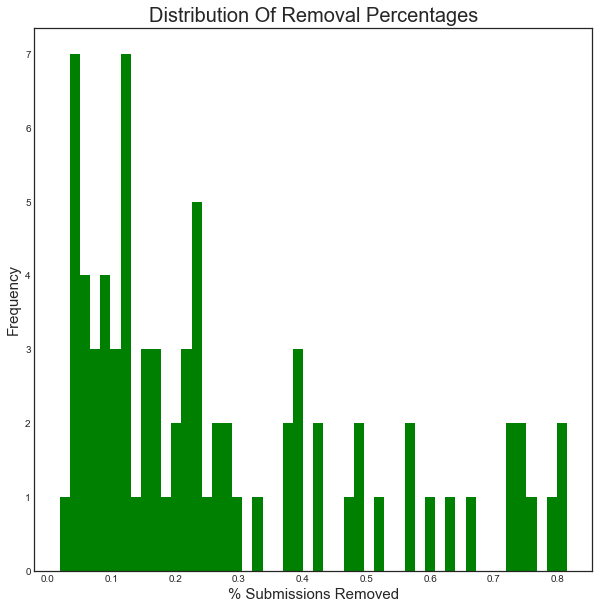

In [10]:
simple_frequency(S_grouped_deletions, path= plot_path, file_name="removal_frequency_submissions", 
                            main_title="Distribution Of Removal Percentages", 
                            main_color ='green',freq_var='rem_perc',
                             xlabel = '% Submissions Removed', ylabel ='Frequency',
                             x_axis_vector=False, 
                             bins = 50,histtype="bar", dpi = 300)

In [11]:
S_grouped_deletions["rem_perc"].describe()

count    78.000000
mean      0.276763
std       0.229492
min       0.018397
25%       0.102371
50%       0.206189
75%       0.396690
max       0.814914
Name: rem_perc, dtype: float64

In [12]:
print(S_grouped_deletions.to_string())

              subreddit   kept  deleted  overall  rem_perc
16              POLITIC  12966      243    13209  0.018397
21            SeattleWA   1507       58     1565  0.037061
28         WayOfTheBern   8079      318     8397  0.037871
52           neoliberal   3071      122     3193  0.038209
1        ChapoTrapHouse  29791     1227    31018  0.039558
58              ontario   1173       50     1223  0.040883
13  LateStageCapitalism   3366      168     3534  0.047538
77        worldpolitics  11571      594    12165  0.048829
24          TheNewRight    768       47      815  0.057669
15             Michigan    719       46      765  0.060131
64              skeptic    508       33      541  0.060998
34             collapse   2254      149     2403  0.062006
49             maryland    519       37      556  0.066547
57       onguardforthee    993       79     1072  0.073694
48              ireland   4810      399     5209  0.076598
12          IndiaSpeaks   6633      651     7284  0.0893

In [13]:
#----------------------------#
# 2.)  Similarity to avg vector
#----------------------------#

In [14]:
# I've computed this back then in subreddit_submission
embed_dict = np.load(data_path + 'embed_dict.npy',allow_pickle='TRUE').item()

In [15]:
def get_subreddit_embeddings(c_S):
    #c_S: current subreddit
    local_embed_list = []
    id_list = c_S["id"].unique().tolist()
    [local_embed_list.append(embed_dict[x]) for x in id_list]
    return(local_embed_list)

In [16]:
def avg_embedding(list_of_embs):
    # averages of vectors should be allowed IF this is a vector
    # https://www.tf.uni-kiel.de/matwis/amat/admat_en/kap_2/basics/b2_1_1.html
    # https://math.stackexchange.com/questions/80923/average-of-multiple-vectors
    out = list_of_embs[0]
    for i in range(1,len(list_of_embs)):
        out = out + list_of_embs[i]
    return(out/len(list_of_embs))

In [17]:
#Old
#Get average embedding
#def avg_embedding_array(emb_matrix):
#    # averages of vectors should be allowed IF this is a vector
#    # https://www.tf.uni-kiel.de/matwis/amat/admat_en/kap_2/basics/b2_1_1.html
#    # https://math.stackexchange.com/questions/80923/average-of-multiple-vectors
#    out = emb_matrix[0,]
#    for i in range(1,emb_matrix.shape[0]):
#        out = out + emb_matrix[i,]
#    return(out/emb_matrix.shape[1])

In [18]:
def reg_df_get(subreddit_string):     
    subreddit_df = S.loc[S["subreddit"] == subreddit_string,].copy()
    emb_list = get_subreddit_embeddings(subreddit_df)
    mean_emb  = avg_embedding(emb_list)
    sim_2_mean_vec = [np.inner(mean_emb, emb_list[i][0])[0] for i in range(0, len(emb_list))]
    #
    subreddit_df["similarity"] = 0
    subreddit_df["similarity"] = sim_2_mean_vec
    return(subreddit_df)

In [19]:
corona_df = reg_df_get("Coronavirus")

In [20]:
#del embed_dict
#del S

In [21]:
#----------------------------#
# 3.) Statistics
#----------------------------#

In [22]:
print(corona_df.loc[corona_df["removed"]==1,"similarity"].mean())
print(corona_df.loc[corona_df["removed"]==0,"similarity"].mean())

0.08158197804999809
0.08824852452516756


In [23]:
import statsmodels.api as sm

In [24]:
#run logit
predictors = sm.add_constant(corona_df["similarity"])
logit_model=sm.Logit(corona_df["removed"],predictors)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.447554
         Iterations 6
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.006     
Dependent Variable: removed          AIC:              5053.3076 
Date:               2020-04-30 16:48 BIC:              5066.5833 
No. Observations:   5641             Log-Likelihood:   -2524.7   
Df Model:           1                LL-Null:          -2539.7   
Df Residuals:       5639             LLR p-value:      3.9643e-08
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     6.0000                                       
------------------------------------------------------------------
              Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
------------------------------------------------------------------
const        -1.1186    0.0947  -11.8107  0.0000  -1.3043  -0.9330
similarity   -5.7975    1.0600   -5.4692  0.0000  -7.8752  -3.

In [25]:
AME = result.get_margeff(at = "mean",method="dydx")
print(AME.summary())
# A unit increase in similarity to the mean decreases the porbability to be deleted 
# by 80%

        Logit Marginal Effects       
Dep. Variable:                removed
Method:                          dydx
At:                              mean
                dy/dx    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
similarity    -0.7975      0.145     -5.516      0.000      -1.081      -0.514


In [26]:
#.)
# Probability at 1
print(np.exp(-1.1186 + -5.7975 )/(1+np.exp(-1.1186 + -5.7975 )))
#2.)
#Threshold:
#interc + similarity*threshold = 0
#thr = -intercept/similarit
print(-1.1186/float(-5.7975 ))
# If the threshold is lower  then this it will be predicted as kept
# Otherwise as deleted

0.0009907075247769367
0.1929452350150927


In [27]:
# Ok I want to find the Point at which the effect of distance on 
# Probability to being deleted is maximal
# I couldn't find the proper method to get the marginal effects at each point
# However following thi great link
#https://stackoverflow.com/questions/34439/finding-what-methods-a-python-object-has
# I could extract ALL methods with dir(AME)
# and margeff seems to do the job
AME = result.get_margeff(at = "all",method="dydx")
margeff_list = AME.margeff

In [28]:
corona_df["ME"] = margeff_list

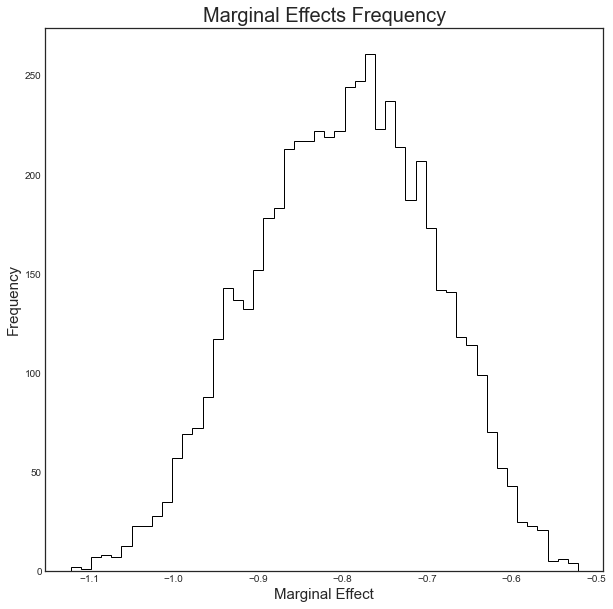

In [29]:
simple_frequency(corona_df, path= plot_path, file_name="Marginal_Effects_Corona", 
                            main_title="Marginal Effects Frequency", 
                            main_color ='black',freq_var='ME',
                             xlabel = 'Marginal Effect', ylabel ='Frequency',
                             x_axis_vector=False, 
                             bins = 50,histtype="step", dpi = 300)

In [30]:
result.predict().shape
# This link below didn't help :/
#https://stackoverflow.com/questions/26528019/python-statsmodel-api-logistic-regression-logit
#predicted = result.predict(corona_df["similarity"].values.T)
#predicted_choice = (predicted > threshold).astype(int)

(5641,)

In [31]:
#Predict 
corona_df["PP"] = result.predict()

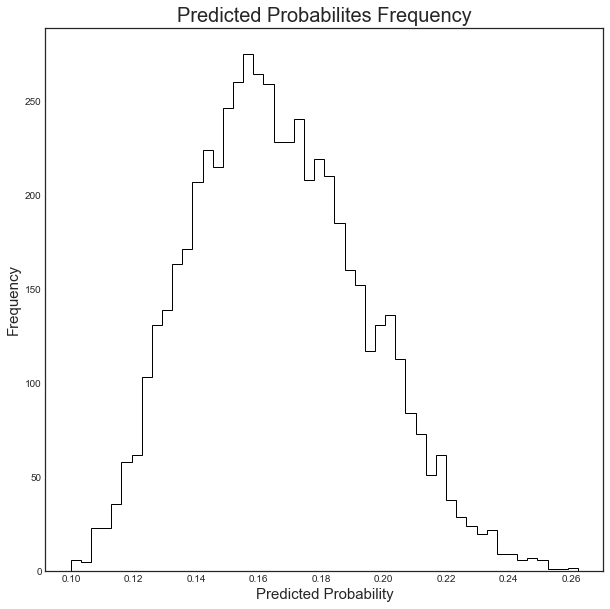

In [32]:
simple_frequency(corona_df, path= plot_path, file_name="Predicted_Probabilities_Corona", 
                            main_title="Predicted Probabilites Frequency", 
                            main_color ='black',freq_var='PP',
                             xlabel = 'Predicted Probability', ylabel ='Frequency',
                             x_axis_vector=False, 
                             bins = 50,histtype="step", dpi = 300)

In [35]:
# CONCLUSION:
# So the maximal probability to be deleted is 26 % 
# 

In [36]:
#----------------------------#
# 4.) All
#----------------------------#

In [37]:
threshold_list = []
effect_list = []
intercept_list = []
quant_05 = []
quant_25 = []
quant_50 = []
quant_75 = []
quant_95 = []
for s in S_grouped_deletions["subreddit"].tolist():
    submissions_df = reg_df_get(s)
    #
    predictors = sm.add_constant(submissions_df["similarity"])
    logit_model=sm.Logit(submissions_df["removed"],predictors)
    result=logit_model.fit()
    #
    threshold_list.append( - result.params[0]/float(result.params[1]))
    effect_list.append(result.params[1])
    intercept_list.append(result.params[0])
    #
    quant_05.append(submissions_df["similarity"].quantile(0.05))
    quant_25.append(submissions_df["similarity"].quantile(0.25))
    quant_50.append(submissions_df["similarity"].quantile(0.50))
    quant_75.append(submissions_df["similarity"].quantile(0.75))
    quant_95.append(submissions_df["similarity"].quantile(0.95))

Optimization terminated successfully.
         Current function value: 0.091676
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.158344
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.159013
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.162154
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.166507
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.166906
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.191187
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.195050
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.218996
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.217739
  

In [38]:
S_grouped_deletions

,subreddit,kept,deleted,overall,rem_perc
16,POLITIC,12966,243,13209,0.018397
21,SeattleWA,1507,58,1565,0.037061
28,WayOfTheBern,8079,318,8397,0.037871
52,neoliberal,3071,122,3193,0.038209
1,ChapoTrapHouse,29791,1227,31018,0.039558
...,...,...,...,...,...
72,usanews,264,767,1031,0.743938
44,healthcare,338,1091,1429,0.763471
11,Health,871,3419,4290,0.796970
43,healthIT,88,384,472,0.813559


In [39]:
S_grouped_deletions["intercept"] = intercept_list
S_grouped_deletions["effect"] = effect_list
S_grouped_deletions["threshold"] = threshold_list
#
S_grouped_deletions["quant_05"] = quant_05
S_grouped_deletions["quant_25"] = quant_25
S_grouped_deletions["quant_50"] = quant_50
S_grouped_deletions["quant_75"] = quant_75
S_grouped_deletions["quant_95"] = quant_95
S_grouped_deletions

,subreddit,kept,deleted,overall,rem_perc,intercept,effect,threshold,quant_05,quant_25,quant_50,quant_75,quant_95
16,POLITIC,12966,243,13209,0.018397,-3.793493,-1.116691,-3.397084,0.036135,0.120138,0.180443,0.221491,0.259922
21,SeattleWA,1507,58,1565,0.037061,-3.061523,-1.891222,-1.618807,0.030971,0.069892,0.101897,0.142686,0.183348
28,WayOfTheBern,8079,318,8397,0.037871,-4.160095,4.377830,0.950264,0.047948,0.136288,0.208403,0.269589,0.308977
52,neoliberal,3071,122,3193,0.038209,-3.347032,1.025851,3.262688,0.029208,0.075689,0.115771,0.160391,0.200928
1,ChapoTrapHouse,29791,1227,31018,0.039558,-3.087292,-1.079535,-2.859835,0.037732,0.068937,0.094097,0.120842,0.158177
...,...,...,...,...,...,...,...,...,...,...,...,...,...
72,usanews,264,767,1031,0.743938,-0.611914,10.972539,0.055768,0.064630,0.130760,0.168882,0.197016,0.230321
44,healthcare,338,1091,1429,0.763471,1.575684,-4.335571,0.363432,0.032008,0.069883,0.093060,0.116077,0.143330
11,Health,871,3419,4290,0.796970,1.229974,1.681595,-0.731433,0.030895,0.063321,0.084153,0.103327,0.127750
43,healthIT,88,384,472,0.813559,-0.274578,13.489463,0.020355,0.020358,0.089994,0.175719,0.206339,0.236147


In [40]:
# Troubleshoot positive intercepts and effects
S_grouped_deletions.loc[(S_grouped_deletions["intercept"]>0) & 
                        (S_grouped_deletions["effect"]>0),]
# Vlad: Most get deleted. So of course avg is not a good thing
# And effect maybe low
# Or maybe redundnacy effect! Different Norms? 

,subreddit,kept,deleted,overall,rem_perc,intercept,effect,threshold,quant_05,quant_25,quant_50,quant_75,quant_95
65,tech,528,1437,1965,0.731298,0.888273,1.545905,-0.574597,0.026008,0.056179,0.074946,0.091616,0.114970
11,Health,871,3419,4290,0.796970,1.229974,1.681595,-0.731433,0.030895,0.063321,0.084153,0.103327,0.127750
32,business,2132,9387,11519,0.814914,1.279910,3.460803,-0.369830,0.018771,0.042067,0.059074,0.076671,0.099312


In [41]:
#
print(len(S_grouped_deletions.loc[(S_grouped_deletions["intercept"]<0) & 
                        (S_grouped_deletions["effect"]<0),]))
S_grouped_deletions.loc[(S_grouped_deletions["intercept"]<0) & 
                        (S_grouped_deletions["effect"]<0),].sort_values("effect")
# For example they really care about futureology, they don't want to posting other stuff
# You can catch the bubble! 
# But what if is negativ? wtf
#Vlad: thinking

43


,subreddit,kept,deleted,overall,rem_perc,intercept,effect,threshold,quant_05,quant_25,quant_50,quant_75,quant_95
49,maryland,519,37,556,0.066547,-1.105183,-20.311642,-0.054411,0.024992,0.056194,0.088708,0.123486,0.154247
10,Futurology,2317,398,2715,0.146593,-0.117296,-18.914152,-0.006201,0.029527,0.072328,0.099057,0.121517,0.150026
14,Libertarian,3848,401,4249,0.094375,-0.648633,-15.728989,-0.041238,0.033069,0.085343,0.119271,0.150192,0.178357
40,environment,2787,382,3169,0.120543,-0.340627,-14.825934,-0.022975,0.037113,0.093474,0.127488,0.155897,0.190787
71,unitedkingdom,3137,846,3983,0.212403,-0.170509,-12.969430,-0.013147,0.024178,0.064430,0.095414,0.124406,0.160324
58,ontario,1173,50,1223,0.040883,-2.195138,-12.934367,-0.169714,0.026203,0.056586,0.080263,0.104828,0.139812
64,skeptic,508,33,541,0.060998,-1.481170,-12.776508,-0.115929,0.045917,0.084231,0.106341,0.128102,0.156047
15,Michigan,719,46,765,0.060131,-1.636554,-12.291679,-0.133143,0.026362,0.064062,0.099053,0.141254,0.186904
8,Economics,1263,206,1469,0.140231,-0.541579,-11.972107,-0.045237,0.039832,0.088530,0.116486,0.142842,0.173962
39,economy,1119,152,1271,0.119591,-1.095002,-9.588658,-0.114198,0.034611,0.072660,0.100849,0.128316,0.156802


In [42]:
S_grouped_deletions.loc[S_grouped_deletions["effect"]>0,]

,subreddit,kept,deleted,overall,rem_perc,intercept,effect,threshold,quant_05,quant_25,quant_50,quant_75,quant_95
28,WayOfTheBern,8079,318,8397,0.037871,-4.160095,4.377830,0.950264,0.047948,0.136288,0.208403,0.269589,0.308977
52,neoliberal,3071,122,3193,0.038209,-3.347032,1.025851,3.262688,0.029208,0.075689,0.115771,0.160391,0.200928
13,LateStageCapitalism,3366,168,3534,0.047538,-3.064408,0.870979,3.518348,0.029908,0.056484,0.075126,0.094839,0.127966
25,The_Mueller,1961,212,2173,0.097561,-2.550859,1.528389,1.668986,0.034365,0.161629,0.232317,0.272323,0.312242
7,DrainTheSwamp,1065,140,1205,0.116183,-2.680701,4.607922,0.581759,0.033320,0.098700,0.143957,0.181437,0.212498
69,trump,2312,313,2625,0.119238,-2.259826,1.856228,1.217429,0.034260,0.076675,0.143880,0.194994,0.233989
54,newzealand,2296,665,2961,0.224586,-1.674154,5.325732,0.314352,0.024680,0.049599,0.069865,0.108727,0.154961
56,nyc,1951,615,2566,0.239673,-1.450849,2.769884,0.523794,0.025965,0.066812,0.105041,0.145279,0.180514
26,USNEWS,377,338,715,0.472727,-0.970550,5.484191,0.176972,0.063984,0.124368,0.161162,0.191743,0.228746
60,pakistan,1256,1176,2432,0.483553,-0.108874,0.404386,0.269234,0.022750,0.055454,0.104089,0.157269,0.198000


In [43]:
S_grouped_deletions.loc[S_grouped_deletions["intercept"]>0,]

,subreddit,kept,deleted,overall,rem_perc,intercept,effect,threshold,quant_05,quant_25,quant_50,quant_75,quant_95
0,CanadaPolitics,975,195,1170,0.166667,0.028365,-13.062346,0.002172,0.028306,0.104653,0.142041,0.178005,0.219819
61,politics,25203,7354,32557,0.225881,0.107480,-6.912916,0.015548,0.077435,0.162262,0.214803,0.249241,0.284460
62,science,2400,931,3331,0.279496,0.128153,-13.057044,0.009815,0.022808,0.061524,0.087881,0.111822,0.141310
4,Conservative,5767,2829,8596,0.329107,0.786323,-11.865088,0.066272,0.033648,0.092687,0.138971,0.174919,0.207732
37,dataisbeautiful,2120,1262,3382,0.373152,1.300865,-19.204315,0.067738,0.029618,0.069704,0.098998,0.128142,0.165682
38,democrats,876,563,1439,0.391244,1.063637,-7.893930,0.134741,0.051986,0.159038,0.209078,0.242031,0.275089
76,worldnews,20911,13595,34506,0.393989,1.390750,-17.092215,0.081367,0.025130,0.077759,0.114391,0.143942,0.180104
33,canada,2600,1716,4316,0.397590,0.869079,-14.589975,0.059567,0.020780,0.062666,0.094118,0.119567,0.148493
47,inthenews,663,479,1142,0.419440,0.244983,-4.905766,0.049938,0.037149,0.086214,0.120102,0.151030,0.185224
19,Republican,808,612,1420,0.430986,1.652860,-13.875762,0.119119,0.035386,0.100895,0.146986,0.187122,0.222179


In [44]:
S_grouped_deletions.loc[S_grouped_deletions["intercept"]<0,]

,subreddit,kept,deleted,overall,rem_perc,intercept,effect,threshold,quant_05,quant_25,quant_50,quant_75,quant_95
16,POLITIC,12966,243,13209,0.018397,-3.793493,-1.116691,-3.397084,0.036135,0.120138,0.180443,0.221491,0.259922
21,SeattleWA,1507,58,1565,0.037061,-3.061523,-1.891222,-1.618807,0.030971,0.069892,0.101897,0.142686,0.183348
28,WayOfTheBern,8079,318,8397,0.037871,-4.160095,4.377830,0.950264,0.047948,0.136288,0.208403,0.269589,0.308977
52,neoliberal,3071,122,3193,0.038209,-3.347032,1.025851,3.262688,0.029208,0.075689,0.115771,0.160391,0.200928
1,ChapoTrapHouse,29791,1227,31018,0.039558,-3.087292,-1.079535,-2.859835,0.037732,0.068937,0.094097,0.120842,0.158177
58,ontario,1173,50,1223,0.040883,-2.195138,-12.934367,-0.169714,0.026203,0.056586,0.080263,0.104828,0.139812
13,LateStageCapitalism,3366,168,3534,0.047538,-3.064408,0.870979,3.518348,0.029908,0.056484,0.075126,0.094839,0.127966
77,worldpolitics,11571,594,12165,0.048829,-2.950444,-0.147536,-19.998196,0.031899,0.091065,0.134762,0.170735,0.204946
24,TheNewRight,768,47,815,0.057669,-2.247864,-4.909424,-0.457867,0.038584,0.078821,0.116874,0.155434,0.189524
15,Michigan,719,46,765,0.060131,-1.636554,-12.291679,-0.133143,0.026362,0.064062,0.099053,0.141254,0.186904


In [45]:
S_grouped_deletions.loc[S_grouped_deletions["subreddit"]=="Coronavirus",]

,subreddit,kept,deleted,overall,rem_perc,intercept,effect,threshold,quant_05,quant_25,quant_50,quant_75,quant_95
5,Coronavirus,4702,939,5641,0.16646,-1.118642,-5.797538,-0.192951,0.031679,0.062947,0.087719,0.111171,0.14294


In [46]:
S_grouped_deletions["threshold"].describe()

count    78.000000
mean     -0.391275
std       2.446934
min     -19.998196
25%      -0.386442
50%      -0.058523
75%       0.109681
max       3.518348
Name: threshold, dtype: float64